In [3]:
%matplotlib inline

# Package and dataset loading

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# Load GOOG stock data

path = 'data/stock_market_data/GOOG.csv'
data = pd.read_csv(path)

data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,19-08-2004,2.390042,2.490664,897427216,2.591785,2.499133,2.499133
1,20-08-2004,2.503118,2.515820,458857488,2.716817,2.697639,2.697639
2,23-08-2004,2.716070,2.758411,366857939,2.826406,2.724787,2.724787
3,24-08-2004,2.579581,2.770615,306396159,2.779581,2.611960,2.611960
4,25-08-2004,2.587302,2.614201,184645512,2.689918,2.640104,2.640104


# Data scaling

In [7]:
# Data preprocessing

from sklearn.preprocessing import MinMaxScaler
price = data[['Close']].copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

# Train test val split

In [8]:
# Split data into training and test set with sliding window method

def split_data(stock, lookback, val_size=0.1):
    data_raw = stock.to_numpy()  # Convert to numpy array
    data = []

    # Create sequences of length `lookback`
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    val_set_size = int(np.round(val_size * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size + val_set_size)

    # Split into training, validation, and test sets
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size+val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size+val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:, :-1, :]
    y_test = data[train_set_size+val_set_size:, -1, :]

    return x_train, y_train, x_val, y_val, x_test, y_test

lookback = 20 # choose sequence length
x_train, y_train, x_val, y_val, x_test, y_test = split_data(price, lookback)

# Check shapes
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_val.shape =', x_val.shape)
print('y_val.shape =', y_val.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (3215, 19, 1)
y_train.shape = (3215, 1)
x_val.shape = (459, 19, 1)
y_val.shape = (459, 1)
x_test.shape = (918, 19, 1)
y_test.shape = (918, 1)


# Train model function

In [9]:
# Train the model
import time

def train_model(model, 
                criterion, 
                optimiser, 
                x_train, y_train,
                x_val=None, y_val=None, 
                num_epochs = 100):
    train_loss = []
    val_loss = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        optimiser.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
        
        if x_val is not None:
            model.eval()
            with torch.no_grad():
                val_outputs = model(x_val)
                val_epoch_loss = criterion(val_outputs, y_val)
                val_loss.append(val_epoch_loss.item())
        else:
            val_loss.append(None)
            
        if epoch % 10 == 0:
            if x_val is not None:
                print(f'Epoch {epoch}, train loss: {loss.item()}, val loss: {val_epoch_loss.item()}')
            else:
                print(f'Epoch {epoch}, train loss: {loss.item()}')
    
    training_time = time.time() - start_time
    print(f'Training time: {training_time}')
    
    return train_loss, val_loss
    

# RNN model

In [10]:
# Define RNN
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# LSTM model

In [11]:
# Define LSTM
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

# GRU model

In [12]:
# Define GRU
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :]) 
        return out

# Hyperparameter tuning

In [13]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)

# Hyperparameters defining
input_dim = 1
output_dim = 1

# Tunable hyperparameters
models = [RNN, LSTM, GRU]
hidden_dim = [32, 64, 128]
num_layers = [2, 3]
num_epochs = [100, 200]
learning_rate = [0.01, 0.001]

In [14]:
# Grid search
tune_start_time = time.time()
results = []
best_mse = float('inf')
best_model = None
for model in models:
    for h_dim in hidden_dim:
        for n_layers in num_layers:
            for n_epoch in num_epochs:
                for lr in learning_rate:
                    y_train_tune = torch.from_numpy(y_train).type(torch.Tensor)
                    y_val_tune = torch.from_numpy(y_val).type(torch.Tensor)
                    print(f'Training {model.__name__} with hidden_dim={h_dim}, num_layers={n_layers}, num_epochs={n_epoch}, lr={lr}')
                    model_instance = model(input_dim=input_dim, hidden_dim=h_dim, num_layers=n_layers, output_dim=output_dim).to(device)
                    criterion = nn.MSELoss()
                    optimiser = torch.optim.Adam(model_instance.parameters(), lr=lr)
                    train_loss, val_loss = train_model(model_instance, 
                                                       criterion, 
                                                       optimiser, 
                                                       x_train, 
                                                       y_train_tune, 
                                                       x_val = x_val, 
                                                       y_val = y_val_tune, 
                                                       num_epochs=n_epoch)
                    
                    # Check mse, save model if its the best
                    mse_instance = np.mean(val_loss)
                    
                    if mse_instance < best_mse:
                        best_mse = mse_instance
                        best_model = model_instance
                        
                    results.append({
                        'model': model.__name__,
                        'hidden_dim': h_dim,
                        'num_layers': n_layers,
                        'num_epochs': n_epoch,
                        'lr': lr,
                        'train_loss': train_loss,
                        'val_loss': val_loss
                    })
tune_time = time.time() - tune_start_time
print(f'Tuning time: {tune_time}')

Training RNN with hidden_dim=32, num_layers=2, num_epochs=100, lr=0.01
Epoch 0, train loss: 0.843235194683075, val loss: 0.022998029366135597
Epoch 10, train loss: 0.037770964205265045, val loss: 0.3678644001483917
Epoch 20, train loss: 0.01745638996362686, val loss: 0.22473447024822235
Epoch 30, train loss: 0.016726475208997726, val loss: 0.151933491230011
Epoch 40, train loss: 0.010581498965620995, val loss: 0.10869301855564117
Epoch 50, train loss: 0.017108513042330742, val loss: 0.07912709563970566
Epoch 60, train loss: 0.0058102477341890335, val loss: 0.017235904932022095
Epoch 70, train loss: 0.0005928181344643235, val loss: 0.012719173915684223
Epoch 80, train loss: 0.000642922124825418, val loss: 0.005425732582807541
Epoch 90, train loss: 0.00031758748809807, val loss: 0.007941589690744877
Training time: 6.202880144119263
Training RNN with hidden_dim=32, num_layers=2, num_epochs=100, lr=0.001
Epoch 0, train loss: 0.2955033779144287, val loss: 0.003509025787934661
Epoch 10, trai

# Best model checking

In [15]:
# Check best model

results_df = pd.DataFrame(results)
results_df['mse'] = results_df['val_loss'].apply(np.mean)
clean_df = results_df.drop(columns=['train_loss', 'val_loss'])
clean_df.sort_values(by='mse', ascending=True).head()

,model,hidden_dim,num_layers,num_epochs,lr,mse
58,GRU,64,2,200,0.010,0.020125
66,GRU,128,2,200,0.010,0.020189
19,RNN,128,2,200,0.001,0.029123
54,GRU,32,3,200,0.010,0.029760
70,GRU,128,3,200,0.010,0.030552


In [17]:
# Get best model values
best_model_results = results_df.sort_values(by='mse', ascending=True).iloc[0]

best_train_loss = best_model_results['train_loss']
best_val_loss = best_model_results['val_loss']

# Best model evaluation

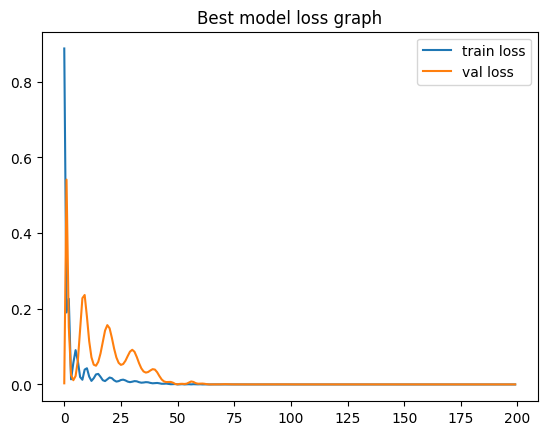

In [18]:
# Plot the best model
plt.plot(best_train_loss, label='train loss')
plt.plot(best_val_loss, label='val loss')
plt.title('Best model loss graph')
plt.legend()
plt.show()

In [19]:
y_test_best = torch.from_numpy(y_test).type(torch.Tensor)

best_model.eval()
with torch.no_grad():
    test_outputs = best_model(x_test)
    test_loss = criterion(test_outputs, y_test_best)
    print(f'Best model MSE: {test_loss.item()}')

Best model MSE: 0.0065952870063483715


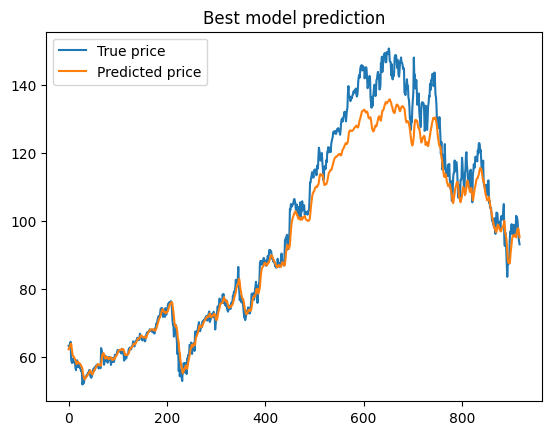

In [20]:
# Descale the data
y_test_descaled = scaler.inverse_transform(y_test_best)
y_test_pred = scaler.inverse_transform(test_outputs)

plt.plot(y_test_descaled, label='True price')
plt.plot(y_test_pred, label='Predicted price')
plt.title('Best model prediction')
plt.legend()
plt.show()
